In [1]:
import re  # for string splitting
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

import cvlib as cv
import pandas as pd
import os
from cvlib.object_detection import draw_bbox
import datetime
from ipywidgets import *
import scipy.stats as st

from matplotlib.colors import LogNorm

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


from scipy.signal import savgol_filter

Using TensorFlow backend.


In [53]:
def gkern(kernlen=34, nsig=5.5):
    """Returns a 2D Gaussian kernel."""
    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

def gkern_1d(kernlen=34, nsig=5.5):
    """Returns a 1D Gaussian kernel."""
    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    return kern1d/kern1d.sum()

def kernel_from_d(d_um=2.2,scaling_factor=0.345):
    '''
    d_um=2.2 # micrometer, smallest feature we want to detect
    scaling_factor=0.345 #pixela/um
    d=d_um/scaling_factor #d in pixels
    sigma=d*0.5*np.sqrt(3) # estimate of a good sigma to use Guesebroek et al.
    cutoff=2*np.ceil(3*sigma)
    '''
    d=d_um/scaling_factor #d in pixels
    sigma=d*0.5*np.sqrt(3) # estimate of a good sigma to use Guesebroek et al.
    print(sigma)
    cutoff=int(2*np.ceil(3*sigma)+1)
    print(cutoff)
    kernel=np.array(gkern(kernlen=cutoff,nsig=sigma))
    
    return kernel,sigma,cutoff

def kernel_from_d_1d(d_um=2.2,scaling_factor=0.345):
    '''
    d_um=2.2 # micrometer, smallest feature we want to detect
    scaling_factor=0.345 #pixela/um
    d=d_um/scaling_factor #d in pixels
    sigma=d*0.5*np.sqrt(3) # estimate of a good sigma to use Guesebroek et al.
    cutoff=2*np.ceil(3*sigma)
    '''
    d=d_um/scaling_factor #d in pixels
    sigma=d*0.5*np.sqrt(3) # estimate of a good sigma to use Guesebroek et al.
    cutoff=int(2*np.ceil(3*sigma)+1)
    
    kernel=np.array(gkern_1d(kernlen=cutoff,nsig=sigma))
    
    return kernel,sigma,cutoff


    

5.5224808357268556
35


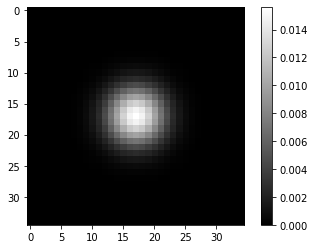

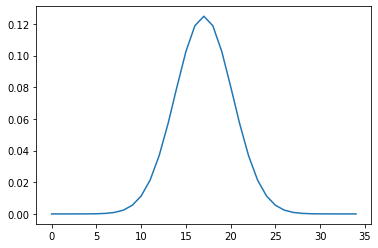

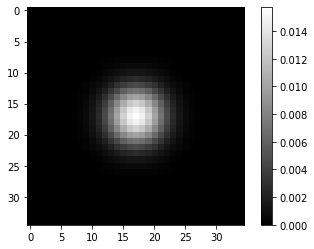

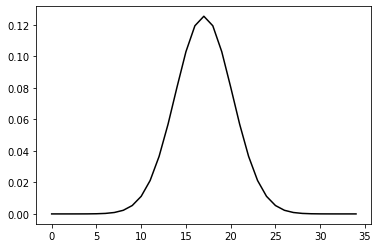

In [54]:

plt.figure()
kernel_2d_gkern=gkern(kernlen=35, nsig=5.5)
plot1=plt.imshow(kernel_2d_gkern,cmap='gray')
plt.colorbar(plot1)

plt.figure()

kernel_gkern=gkern_1d(kernlen=35, nsig=5.5)
plt.plot(kernel_gkern)

plt.figure()
kernel_2d,sigma,cutoff=kernel_from_d()
plot2=plt.imshow(kernel_2d,cmap='gray')
plt.colorbar(plot2)

plt.figure()
kernel,sigma,cutoff=kernel_from_d_1d()
plt.plot(kernel,c='black')




In [55]:
def convolve_img(img,column_conv,row_conv):
    '''https://www.crisluengo.net/archives/150'''
    
    #first convolve with column_conv (derivative of gaussian)
    #then convolve with row_conv (gaussian)
    
    
    return result #same size as input img, the central part of the convolution

/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Results_200311/Scans/minus_3_04-03112020115915-0.png_2_x460_y930_r28_cut2.png
5.5224808357268556
35
251.0218561694025
1509


Text(0.5, 1.0, 'filtered2')

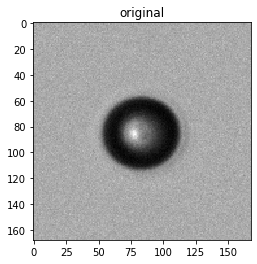

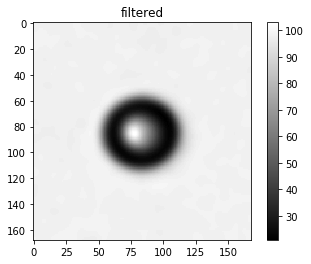

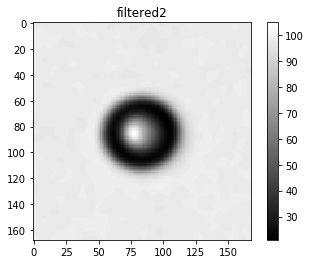

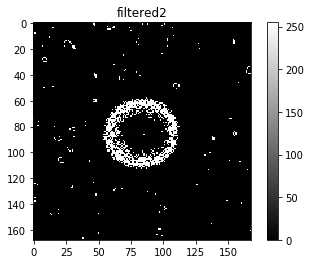

In [58]:
PATH = os.path.join(os.getcwd(), 'Results_200311/Scans')
file_name='minus_3_04-03112020115915-0.png_2_x460_y930_r28_cut2.png'

path_to_image=os.path.join(PATH,file_name)
print(path_to_image)

image = cv2.imread(path_to_image)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(image_gray,cmap='gray')
plt.title('original')


plt.figure()
src=image_gray
ddepth=-1 #same as original
kernel,sigma,cutoff=kernel_from_d(d_um=2.2)
filtered=cv2.filter2D(src,ddepth,kernel)
plt.imshow(filtered,cmap='gray')
plt.colorbar()
plt.title('filtered')


plt.figure()
src=image_gray
ddepth=-1 #same as original
kernel2,sigma2,cutoff=kernel_from_d(d_um=100)
filtered2=cv2.filter2D(src,ddepth,kernel2)
plt.imshow(filtered2,cmap='gray')
plt.colorbar()
plt.title('filtered2')


plt.figure()
plt.imshow(np.subtract(filtered2,filtered),cmap='gray')
plt.colorbar()
plt.title('filtered2')

In [59]:
kernel,sigma,cutoff=kernel_from_d()



5.5224808357268556
35


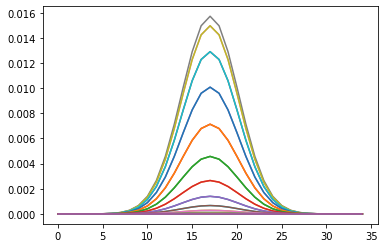

In [60]:
plt.plot(kernel)

 ...]

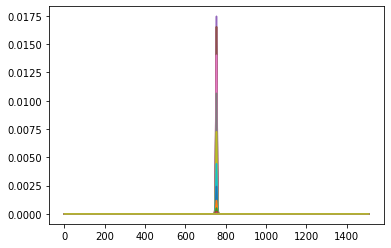

In [61]:
plt.plot(kernel2)

In [39]:
sigma

5.5224808357268556

In [40]:
sigma2

251.0218561694025